In [57]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [58]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [110]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

validation = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


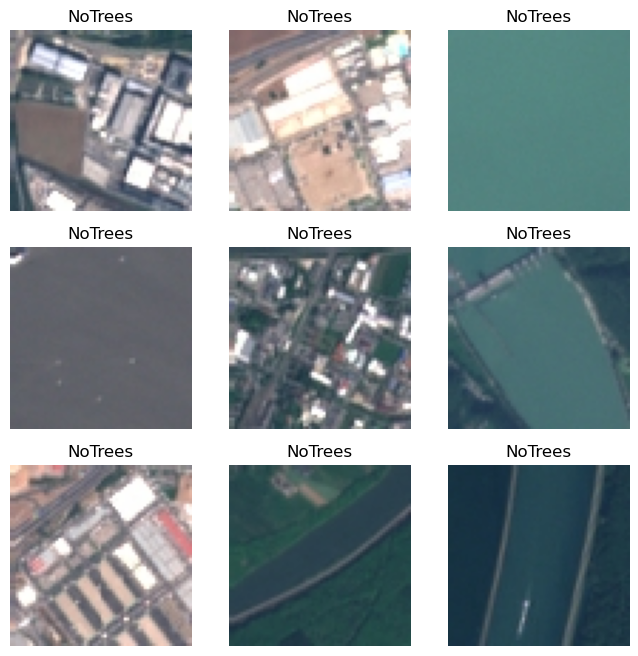

In [111]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [112]:
#split the validation dataset into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation)
test_ds = validation.take(val_batches // 5) #test set
validation_ds = validation.skip(val_batches // 5) #validation set

In [113]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 104
Number of test batches: 26


In [114]:
# performance configuration: Use buffered prefetching to load images from disk
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

I will use transfer learning with a pre-trained network as a starting point for this classification task, and compare to the from-scratch networks that I built. The idea behind transfer learning for image classification is that if a model is trained on a large, general dataset, it will effectively serve as a generic model that can then be applied to other datasets by allowing you to take advantage of these learned feature maps. I first tried using the MobileNet V2 model developed by Google, which is pre-trained on the ImageNet dataset (1.4M images, 1000 classes). This Notebook will try ResNet50

The ResNet50 model expects pixel values from [-1,1] instead of the [0,255] that the images are in currently. So I will first need to rescale them:

In [64]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [65]:
# Create the base model from the pre-trained model ResNet50
from tensorflow.keras.applications import ResNet50
img_size = (64,64)
img_shape = img_size + (3,)
base_model = ResNet50(input_shape=img_shape, include_top=False, weights='imagenet')

In [66]:
# convert each image into a block of features
image_batch, label_batch = next(iter(training))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 2, 2, 2048)


In [67]:
# Freeze the convolutional base before compiling and training the model. This prevents the weights
# in a given layer from being updated before training. 
base_model.trainable = False

In [68]:
# Let's see the base model's summary
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [69]:
# generate predictions from the block of features by averaging over the 2x2 spatial locations, 
# using a GlobalAveragePooling2D layer to convert the features to a single 
# 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [70]:
# Apply a Dense layer to convert these features into a single prediction per image. 
# no activation function here because this prediction will be treated as a logit (raw prediction value)
#Positive numbers predict class 1, negative numbers class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [71]:
#build a model with rescaling, basemodel, and feature extrator layers
inputs = tf.keras.Input(shape=img_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [72]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [74]:
len(model.trainable_variables)

2

The 23.6 million ResNet50 parameters are frozen but there are about 2000 trainable parameters in the Dense output layer (divided between 2 tf variable objects -  weights and biases).

In [75]:
#train the model for 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

130/130 [==============================] - 27s 196ms/step - loss: 0.9628 - accuracy: 0.4773
initial loss: 0.96
initial accuracy: 0.48


In [76]:
from time import time
start = time()

history = model.fit(training,
                    epochs=initial_epochs,
                    validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/10
517/517 [==============================] - 132s 246ms/step - loss: 0.5957 - accuracy: 0.7224 - val_loss: 0.2763 - val_accuracy: 0.8611
Epoch 2/10
517/517 [==============================] - 127s 246ms/step - loss: 0.2643 - accuracy: 0.9018 - val_loss: 0.1914 - val_accuracy: 0.9076
Epoch 3/10
517/517 [==============================] - 134s 260ms/step - loss: 0.1934 - accuracy: 0.9361 - val_loss: 0.1478 - val_accuracy: 0.9298
Epoch 4/10
517/517 [==============================] - 140s 271ms/step - loss: 0.1546 - accuracy: 0.9504 - val_loss: 0.1231 - val_accuracy: 0.9405
Epoch 5/10
517/517 [==============================] - 146s 282ms/step - loss: 0.1334 - accuracy: 0.9569 - val_loss: 0.1114 - val_accuracy: 0.9463
Epoch 6/10
517/517 [==============================] - 140s 272ms/step - loss: 0.1178 - accuracy: 0.9629 - val_loss: 0.0807 - val_accuracy: 0.9637
Epoch 7/10
517/517 [==============================] - 132s 255ms/step - loss: 0.1087 - accuracy: 0.9654 - val_loss: 0.0887 -

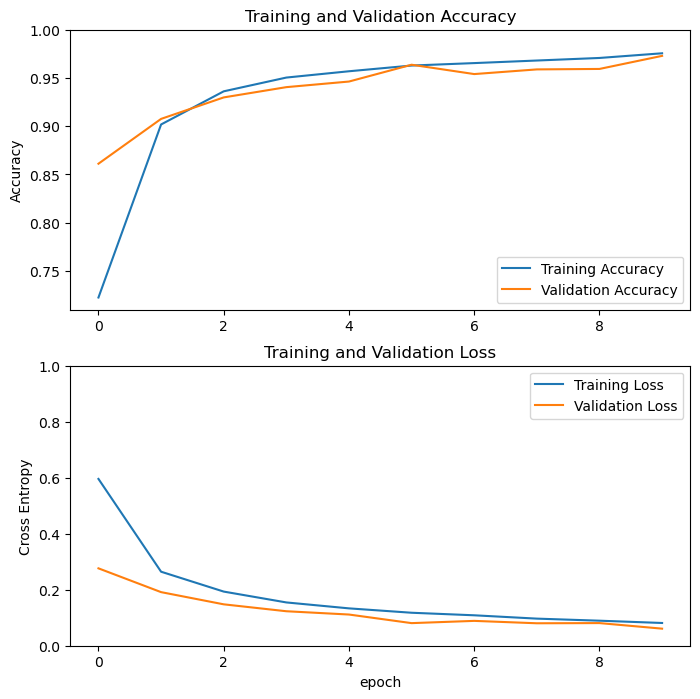

In [77]:
#plot training and validation learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In this feature extraction model, I only added a dense output layer to the ResNet50 model, and the weights of the pre-trained model were not updated during training. Training time was considerably longer with the ResNet50 model compared to MobileNetV2. It achieved about 97% training and validation accuracy and about 0.06 validation loss.

Next, I will take a look at fine-tuning the weights of the top layers of the pretrained model also. This will change the weights to being tuned to generic feature maps to maps of features more specifically associated with the forest satellite image dataset.

In [43]:
# So I will unfreeze the base model so that I can fine tune a few top layers. 
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [45]:
# Fine-tune from this layer onwards
fine_tune_at = 165

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Before compiling the new model, I will change the learning rate to 0.00001. A lower learning rate is important to not overfit too quickly when training a much larger model than the previous feature extraction model.

In [48]:
#use a lower learning rate

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [50]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 306s 584ms/step - loss: 0.0677 - accuracy: 0.9770 - val_loss: 0.0521 - val_accuracy: 0.9748
Epoch 11/20
517/517 [==============================] - 255s 493ms/step - loss: 0.0335 - accuracy: 0.9881 - val_loss: 0.0314 - val_accuracy: 0.9864
Epoch 12/20
517/517 [==============================] - 253s 490ms/step - loss: 0.0182 - accuracy: 0.9938 - val_loss: 0.0201 - val_accuracy: 0.9923
Epoch 13/20
517/517 [==============================] - 253s 489ms/step - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.0268 - val_accuracy: 0.9894
Epoch 14/20
517/517 [==============================] - 256s 495ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0183 - val_accuracy: 0.9937
Epoch 15/20
517/517 [==============================] - 244s 472ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0282 - val_accuracy: 0.9903
Epoch 16/20
517/517 [==============================] - 229s 443ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0

In [51]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim([0,1.0])
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.8,1])
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

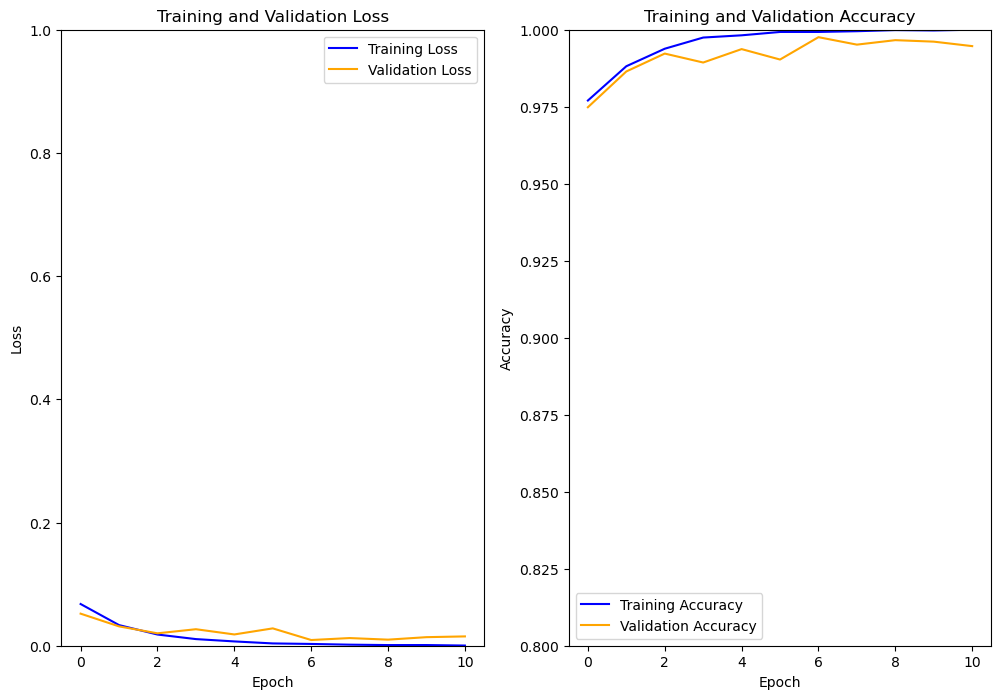

In [52]:
fine_tuned_plots = plot_learning_curve(history_finetuned)

So validation loss and accuracy are definitely improved from the feature extractor model, at close to 100% training and validation accuracy. But training took a very long time, around 48 minutes, by training the top 10 layers. Let's try fine tuning only the 4 top layers and see if that gives a good trade off between accuracy and training time.

In [79]:
base_model.trainable = True

In [80]:
# Fine-tune from this layer onwards
fine_tune_at = 171

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [81]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_2   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [82]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned_2 = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 150s 283ms/step - loss: 0.0723 - accuracy: 0.9763 - val_loss: 0.0739 - val_accuracy: 0.9613
Epoch 11/20
517/517 [==============================] - 138s 267ms/step - loss: 0.0632 - accuracy: 0.9798 - val_loss: 0.0748 - val_accuracy: 0.9627
Epoch 12/20
517/517 [==============================] - 141s 272ms/step - loss: 0.0568 - accuracy: 0.9811 - val_loss: 0.0574 - val_accuracy: 0.9743
Epoch 13/20
517/517 [==============================] - 154s 298ms/step - loss: 0.0535 - accuracy: 0.9823 - val_loss: 0.0522 - val_accuracy: 0.9792
Epoch 14/20
517/517 [==============================] - 156s 301ms/step - loss: 0.0476 - accuracy: 0.9844 - val_loss: 0.0449 - val_accuracy: 0.9816
Epoch 15/20
517/517 [==============================] - 147s 284ms/step - loss: 0.0455 - accuracy: 0.9862 - val_loss: 0.0521 - val_accuracy: 0.9758
Epoch 16/20
517/517 [==============================] - 136s 263ms/step - loss: 0.0414 - accuracy: 0.9863 - val_loss: 0

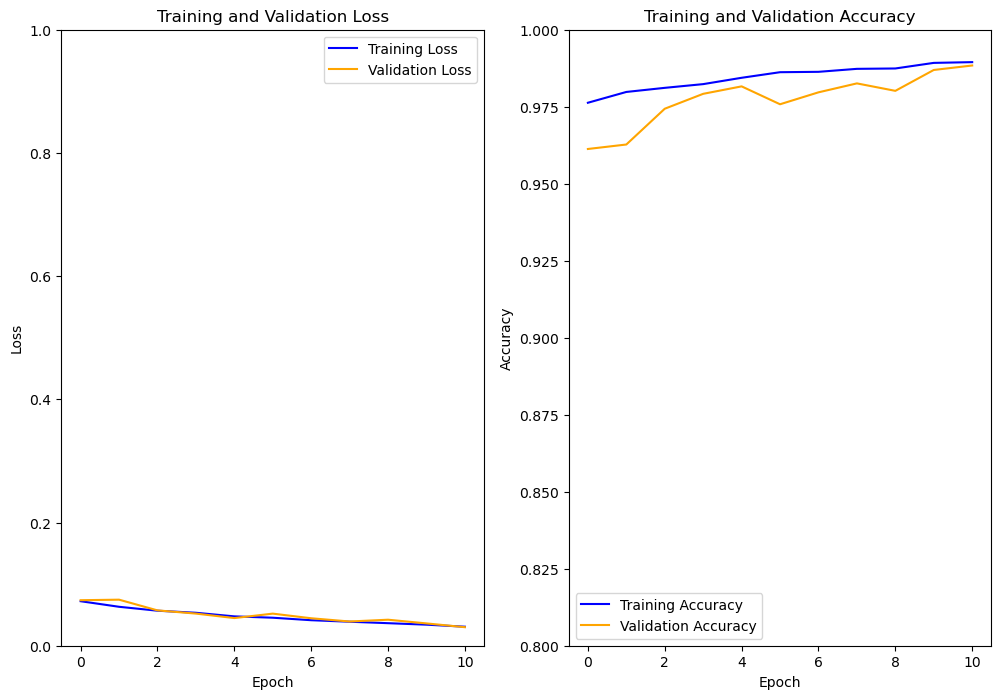

In [83]:
fine_tuned_plots_2 = plot_learning_curve(history_finetuned_2)

So fine-tuning the weights of the top 4 layers was considerably faster (~27 minutes vs 48 minutes) than training the weights of the top 10 layers, and leads to validation accuracy just under 99% and validation loss around 0.03 to 0.04. This is still over twice the training time for slightly worse accuracy compared to the MobileNetV2 model.

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Predictions:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Labels:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


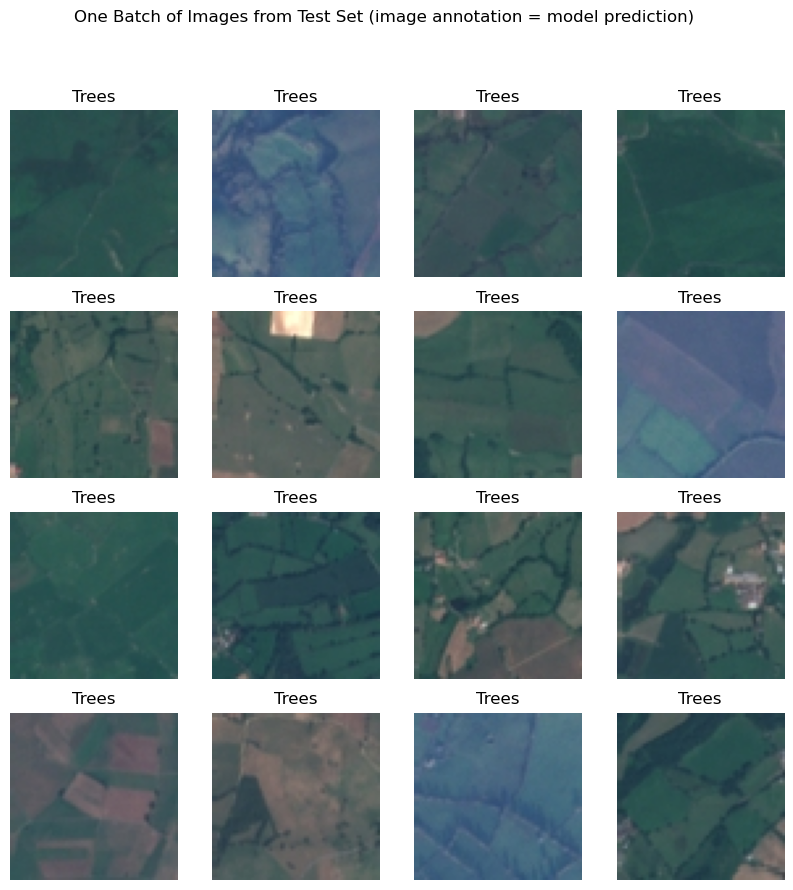

In [97]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(type(test_ds))
label_batch = label_batch.flatten()
label_batch = [int(x) for x in label_batch]
    
# Apply a sigmoid since the model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1) #assign class 0 if probability less than 0.5, otherwise class 1
predictions = list(predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
  plt.suptitle("One Batch of Images from Test Set (image annotation = model prediction)")


In [115]:
test_labels = []
test_img = []
for images, labels in test_ds.unbatch():
    test_img.append(images)
    test_labels.append(labels) # or labels.numpy().argmax() for int labels

In [116]:
test_labels = [int(x) for x in test_labels]
print(test_labels)

[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 

In [118]:
val_labels = []
val_img = []
for images, labels in validation_ds.unbatch():
    val_img.append(images)
    val_labels.append(labels)

val_labels = [int(x) for x in val_labels]
print(val_labels)

[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

In [109]:
tr_labels = []
tr_img = []
for images, labels in training_ds.unbatch():
    tr_img.append(images)
    tr_labels.append(labels)
    
tr_labels = [int(x) for x in tr_labels]
print(tr_labels)

[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 